Estimated mean of the output random vector : 1.00181
Variance of the estimated mean of the output random vector : 0.00001
Standard deviation : 0.00259
Normal(mu = 1.00181, sigma = 0.0025921)


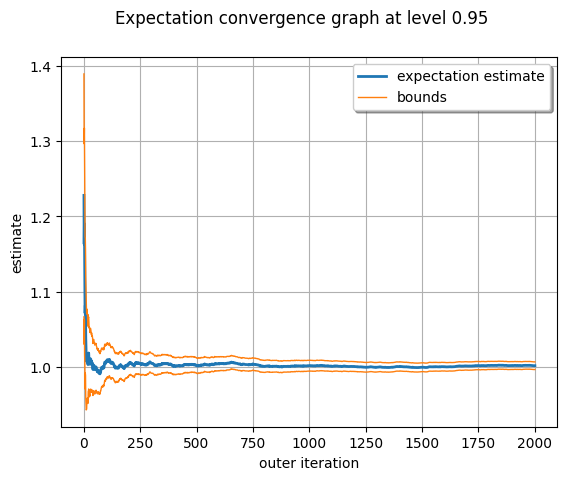

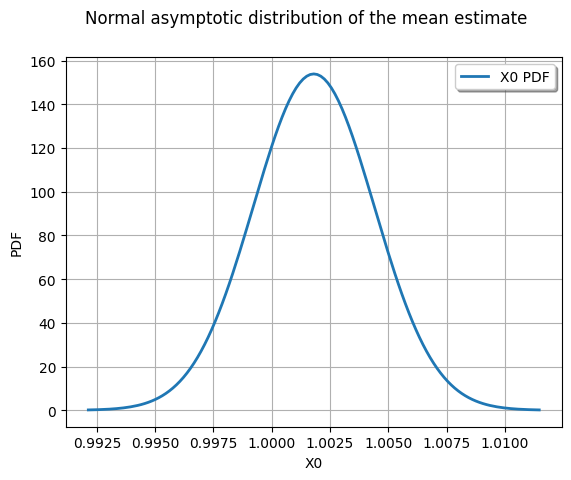

In [11]:
"""
Evaluate the mean of a random vector by simulations
===================================================
"""

import openturns as ot
import importlib.util
import sys
import os
import openturns.viewer as otv
from matplotlib import pylab as plt
import pandas as pd

# Load the flood model
module_name = "FloodModel"
file_path = "examples/FloodModel.py"
output_csv_path = "results/expectation_convergence.csv"
os.makedirs("results", exist_ok=True)

if not os.path.exists(file_path):
    raise FileNotFoundError(f"File {file_path} does not exist.")

spec = importlib.util.spec_from_file_location(module_name, file_path)
if spec is None:
    raise ImportError(f"Could not load the module from {file_path}.")

module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)

function_of_interest, problem = module.model, module.problem

# Create distributions
distributions = ot.DistributionCollection()
for dist_info in problem['distributions']:
    dist_type = dist_info['type']
    params = dist_info['params']
    if dist_type == 'Uniform':
        distributions.add(ot.Uniform(*params))
    elif dist_type == 'Normal':
        distributions.add(ot.Normal(*params))
    elif dist_type == 'LogNormalMuSigma':
        distributions.add(ot.ParametrizedDistribution(ot.LogNormalMuSigma(*params)))
    elif dist_type == 'LogNormal':
        distributions.add(ot.LogNormal(*params))
    elif dist_type == 'Beta':
        distributions.add(ot.Beta(*params))
    elif dist_type == 'Gumbel':
        distributions.add(ot.Gumbel(*params))
    elif dist_type == 'Triangular':
        distributions.add(ot.Triangular(*params))
    else:
        raise ValueError(f"Unsupported distribution type: {dist_type}")

distribution = ot.ComposedDistribution(distributions)

# Define the OpenTURNS model
ot_model = ot.PythonFunction(problem['num_vars'], 1, function_of_interest)

# Create the input distribution
input_vector = ot.RandomVector(distribution)

# The output vector is a CompositeRandomVector
output_vector = ot.CompositeRandomVector(ot_model, input_vector)

# Define the algorithm
algo = ot.ExpectationSimulationAlgorithm(output_vector)
algo.setMaximumOuterSampling(8000)
algo.setBlockSize(1)
algo.setCoefficientOfVariationCriterionType("NONE")

# Run the algorithm and store the result
algo.run()
result = algo.getResult()

# Draw the convergence history
graphConvergence = algo.drawExpectationConvergence()
view = otv.View(graphConvergence)

# Save the convergence data to a CSV file
data = graphConvergence.getDrawable(0).getData()
sample_sizes = data[:, 0]
mean_estimates = data[:, 1]

# Compute standard deviations for the mean estimates
standard_deviations = result.getStandardDeviation()

# Calculate confidence intervals
z_value = 1.96  # For a 95% confidence interval
lower_bounds = mean_estimates - z_value * standard_deviations
upper_bounds = mean_estimates + z_value * standard_deviations


df = pd.DataFrame({
    "Sample Size": [point[0] for point in sample_sizes],
    "Mean Estimate": [point[0] for point in mean_estimates],
    "Lower Bound": [point[0] for point in lower_bounds],
    "Upper Bound": [point[0] for point in upper_bounds]
})
df.to_csv(output_csv_path, index=False)

# Get the expected value of the mean
expectation = result.getExpectationEstimate()
print("Estimated mean of the output random vector : %.5f" % expectation[0])

# Get the variance and standard deviation of the estimated mean
expectationVariance = result.getVarianceEstimate()
print("Variance of the estimated mean of the output random vector : %.5f" % expectationVariance[0])
standardDeviation = result.getStandardDeviation()
print("Standard deviation : %.5f" % standardDeviation[0])

# The asymptotic confidence distribution of the output random vector mean estimate
expectationDistribution = result.getExpectationDistribution()
print(expectationDistribution)

# Draw the expectation distribution
graphExpectationDistribution = expectationDistribution.drawPDF()
graphExpectationDistribution.setTitle("Normal asymptotic distribution of the mean estimate")
view = otv.View(graphExpectationDistribution)

# Display all figures
plt.show()


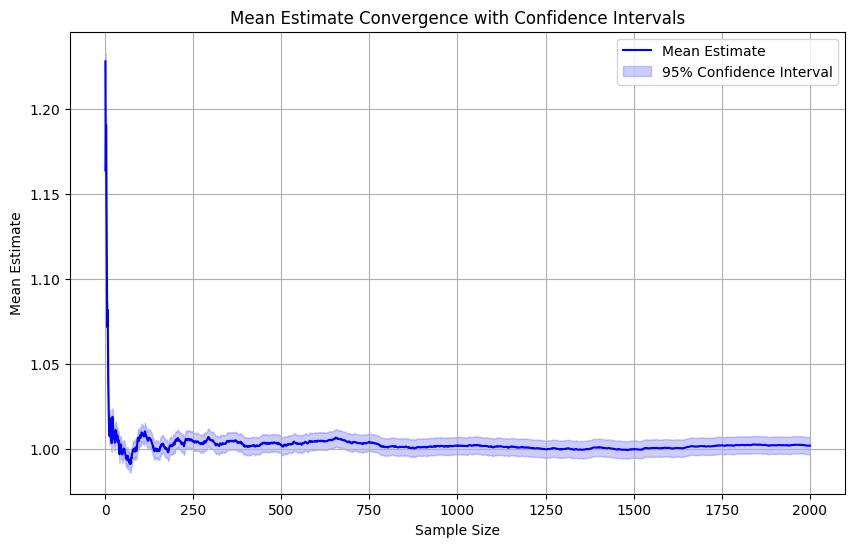

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Load the CSV file
csv_file = "results/expectation_convergence.csv"
data = pd.read_csv(csv_file)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot the mean estimates
plt.plot(data['Sample Size'], data['Mean Estimate'], label='Mean Estimate', color='blue')

# Plot the confidence intervals
plt.fill_between(np.array(data['Sample Size'], dtype=float),np.array(data['Lower Bound'], dtype=float), np.array(data['Upper Bound'], dtype=float), color='blue', alpha=0.2, label='95% Confidence Interval')



# Adding titles and labels
plt.title('Mean Estimate Convergence with Confidence Intervals')
plt.xlabel('Sample Size')
plt.ylabel('Mean Estimate')
plt.legend()
plt.grid(True)

# Save the plot
output_image_path = "results/mean_estimate_convergence_plot.png"
plt.savefig(output_image_path)

# Show the plot
plt.show()


In [ ]:
# Here's a separate Python script to visualize the data from the created CSV file. The script will read the CSV file and plot the mean estimates along with their confidence intervals using `matplotlib`.

# ### Visualization Script

# ```python
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Load the CSV file
csv_file = "results/expectation_convergence.csv"
data = pd.read_csv(csv_file)

# Plot the data
plt.figure(figsize=(10, 6))

# Plot the mean estimates
plt.plot(data['Sample Size'], data['Mean Estimate'], label='Mean Estimate', color='blue')

# Plot the confidence intervals
plt.fill_between(np.array(data['Sample Size'], dtype=float),np.array(data['Lower Bound'], dtype=float), np.array(data['Upper Bound'], dtype=float), color='blue', alpha=0.2, label='95% Confidence Interval')



# Adding titles and labels
plt.title('Mean Estimate Convergence with Confidence Intervals')
plt.xlabel('Sample Size')
plt.ylabel('Mean Estimate')
plt.legend()
plt.grid(True)

# Save the plot
output_image_path = "results/mean_estimate_convergence_plot.png"
plt.savefig(output_image_path)

# Show the plot
plt.show()

# ```

# ### Explanation and Comments

# 1. **Importing Libraries**:
#    - The script uses `pandas` for data manipulation and `matplotlib` for plotting.

# 2. **Loading the CSV File**:
#    - The CSV file `results/expectation_convergence.csv` is loaded into a pandas DataFrame. This file contains the convergence data from the Expectation Simulation Algorithm.

# 3. **Plotting the Data**:
#    - A figure is created to visualize the data. The sample size is plotted on the x-axis, and the mean estimates are plotted on the y-axis.
#    - The mean estimates are plotted as a blue line.
#    - The confidence intervals are represented by shaded areas around the mean estimates. The `fill_between` function is used to fill the area between the lower and upper bounds, providing a visual representation of the 95% confidence interval.

# 4. **Adding Titles and Labels**:
#    - The plot includes a title, x-axis label, y-axis label, and a legend to describe the different components of the plot.
#    - The grid is enabled for better readability.

# 5. **Saving and Showing the Plot**:
#    - The plot is saved as an image file `results/mean_estimate_convergence_plot.png`.
#    - The plot is displayed on the screen.

# ### What the Data Represents and How to Analyze It

# #### Data Description

# The CSV file `expectation_convergence.csv` contains the following columns:
# - **Sample Size**: The number of samples used in the Monte Carlo simulation.
# - **Mean Estimate**: The estimated mean of the output random vector at each sample size.
# - **Lower Bound**: The lower bound of the 95% confidence interval for the mean estimate.
# - **Upper Bound**: The upper bound of the 95% confidence interval for the mean estimate.

# #### Analysis

# 1. **Convergence of Mean Estimates**:
#    - The plot shows how the mean estimate of the output random vector evolves as the sample size increases. This helps to understand the convergence behavior of the Monte Carlo simulation.

# 2. **Confidence Intervals**:
#    - The shaded area around the mean estimate represents the 95% confidence interval. As the sample size increases, the confidence interval typically narrows, indicating increased precision in the mean estimate.

# 3. **Stability of the Mean Estimate**:
#    - By observing the plot, you can assess the stability of the mean estimate. If the mean estimate stabilizes and the confidence interval becomes narrow as the sample size increases, it indicates that the simulation is converging to a reliable estimate of the mean.

# 4. **Significance of the Confidence Intervals**:
#    - The confidence intervals provide a measure of uncertainty around the mean estimate. A narrow confidence interval indicates high confidence in the estimate, while a wide interval suggests more variability and less certainty.

# This visualization provides valuable insights into the behavior of the Monte Carlo simulation and the reliability of the mean estimate as more samples are considered.